In [246]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

# GOAL: Predicting OKC Thunder's Future Based on Their Draft Picks

## Create new dataframe for league standings from 1985-2022 (2022-23 season)

### Option 1: Create from scratch (Timeouts may occur)

In [247]:
from nba_api.stats.endpoints import leaguestandings
league_standings = pd.DataFrame()

#starts at 1985, when the lottery starts
for year in range (1985, 2023):
    year = str(year)
    yearly_standings = leaguestandings.LeagueStandings(season=year) #Timeouts may occur here
    yearly_standings = yearly_standings.get_data_frames()
    league_standings = pd.concat([league_standings, yearly_standings[0]])
    
league_standings.reset_index(inplace=True)
league_standings.drop(['index'], axis=1, inplace=True)
#league_standings.to_csv('league_standings.csv')

In [248]:
league_standings

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS,vsSoutheast,vsNorthwest,vsSouthwest
0,00,21985,1610612747,Los Angeles,Lakers,West,47-13,1,,Pacific,...,None,None,None,None,None,37-11,25-9,NaN,NaN,NaN
1,00,21985,1610612738,Boston,Celtics,East,48-10,1,,Atlantic,...,None,None,None,None,None,38-8,29-7,NaN,NaN,NaN
2,00,21985,1610612745,Houston,Rockets,West,38-22,2,,Midwest,...,None,None,None,None,None,33-16,18-15,NaN,NaN,NaN
3,00,21985,1610612749,Milwaukee,Bucks,East,39-19,2,,Central,...,None,None,None,None,None,33-18,24-7,NaN,NaN,NaN
4,00,21985,1610612743,Denver,Nuggets,West,34-26,3,,Midwest,...,None,None,None,None,None,30-21,17-14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,00,22022,1610612757,Portland,Trail Blazers,West,23-29,13,- o,Northwest,...,None,None,5-1,6-10,7-6,28-30,5-19,6-4,7-9,10-8
1083,00,22022,1610612745,Houston,Rockets,West,12-40,14,- o,Southwest,...,None,None,1-7,4-9,5-10,13-45,9-15,4-6,5-13,4-12
1084,00,22022,1610612766,Charlotte,Hornets,East,15-37,14,- o,Southeast,...,None,None,3-4,3-11,4-12,17-43,10-12,7-9,4-6,5-5
1085,00,22022,1610612759,San Antonio,Spurs,West,10-42,15,- o,Southwest,...,None,None,5-2,1-14,6-8,14-45,8-15,3-7,6-12,3-13


### Option 2: Load pre-saved file from the above code

In [249]:
# #Load league standings if the above portion do not work (timeouts)
# league_standings = pd.read_csv('league_standings.csv')

# #Drops first two columns
# league_standings.drop(league_standings.columns[0], axis = 1, inplace = True)
# league_standings.drop(league_standings.columns[0], axis = 1, inplace = True)

# #Changing LeagueID back to 00
# league_standings['LeagueID'] = '00'

## Filter for Low Seeded Teams

### Find the bottom 6 teams from each season (13-15 playoff rank). Use SeasonID to filter.

In [250]:
league_standings['TeamID']=league_standings['TeamID'].astype('str')
league_standings['SeasonID'] = league_standings['SeasonID'].astype('int')

In [251]:
league_standings['PreviousRank']=np.nan
league_standings['NewTeam']=False
min_season = league_standings['SeasonID'].unique().min()
for season in league_standings['SeasonID'].unique():
    season = int(season)
    prev_season = season-1
    if (prev_season >= min_season):
        for team in league_standings[league_standings['SeasonID']==season]['TeamID']:
            firstmask = league_standings['SeasonID']==season
            secondmask = league_standings['TeamID']==team
            thirdmask = league_standings['SeasonID']==prev_season
            cond1 = league_standings[firstmask & secondmask]
            cond2 = league_standings[thirdmask & secondmask]
            ind1 = cond1.index[0]
            if (cond2.empty): #New Expansion Team
                league_standings.at[ind1, 'NewTeam'] = True
                league_standings.at[ind1, 'PreviousRank'] = np.nan
            else:
                ind2 = cond2.index[0]
                league_standings.at[ind1, 'PreviousRank'] = league_standings.at[ind2, 'PlayoffRank']

In [252]:
def threshold(season):
    bottom = league_standings[league_standings['SeasonID']==season]['PlayoffRank'].max()
    return bottom-2

In [253]:
def tank(team, season, tank_year):     
    secondmask = league_standings['SeasonID']==season
    cond1 = league_standings[firstmask & secondmask]
    cond2 = cond1['PlayoffRank'] >= threshold(season)
    if (season != min_season):
        if(cond2.bool()):
            tank_year = tank_year+1
            if (cond1['NewTeam'].bool()):
                return tank_year
            else:
                return tank(team, season-1, tank_year)
        else:
            return tank_year
    elif (cond2.bool()):
        tank_year = tank_year+1
        return tank_year
    else:
        return tank_year

### Add new column: Tank length (Year spent as a low seeded team)

In [254]:
league_standings['TankLength']=np.nan
for season in reversed(league_standings['SeasonID'].unique()):
    #print(season)
    bottom = league_standings[league_standings['SeasonID']==season]['PlayoffRank'].max()
    for team in league_standings['TeamID'].unique():
        firstmask = league_standings['TeamID']==team       
        secondmask = league_standings['SeasonID']==season
        cond1 = league_standings[firstmask & secondmask]
        cond2 = cond1['PlayoffRank'] >= threshold(season)
        if not (cond1.empty):
            team_index = cond1.index[0]
            league_standings.at[team_index, 'TankLength'] = tank(team,season,0)

In [255]:
league_standings

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,Nov,Dec,PreAS,PostAS,vsSoutheast,vsNorthwest,vsSouthwest,PreviousRank,NewTeam,TankLength
0,00,21985,1610612747,Los Angeles,Lakers,West,47-13,1,,Pacific,...,None,None,37-11,25-9,NaN,NaN,NaN,NaN,False,0.00
1,00,21985,1610612738,Boston,Celtics,East,48-10,1,,Atlantic,...,None,None,38-8,29-7,NaN,NaN,NaN,NaN,False,0.00
2,00,21985,1610612745,Houston,Rockets,West,38-22,2,,Midwest,...,None,None,33-16,18-15,NaN,NaN,NaN,NaN,False,0.00
3,00,21985,1610612749,Milwaukee,Bucks,East,39-19,2,,Central,...,None,None,33-18,24-7,NaN,NaN,NaN,NaN,False,0.00
4,00,21985,1610612743,Denver,Nuggets,West,34-26,3,,Midwest,...,None,None,30-21,17-14,NaN,NaN,NaN,NaN,False,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,00,22022,1610612757,Portland,Trail Blazers,West,23-29,13,- o,Northwest,...,6-10,7-6,28-30,5-19,6-4,7-9,10-8,13.00,False,2.00
1083,00,22022,1610612745,Houston,Rockets,West,12-40,14,- o,Southwest,...,4-9,5-10,13-45,9-15,4-6,5-13,4-12,15.00,False,3.00
1084,00,22022,1610612766,Charlotte,Hornets,East,15-37,14,- o,Southeast,...,3-11,4-12,17-43,10-12,7-9,4-6,5-5,10.00,False,1.00
1085,00,22022,1610612759,San Antonio,Spurs,West,10-42,15,- o,Southwest,...,1-14,6-8,14-45,8-15,3-7,6-12,3-13,10.00,False,1.00


### Add new column: Highest and second highest draft pick


In [256]:
tanking_table = league_standings.copy()
tanking_table.drop(columns=['LeagueID', 'Conference','ConferenceRecord','ClinchIndicator', 'Division',
                           'DivisionRecord', 'DivisionRank', 'WINS', 'LOSSES','WinPCT','HOME', 'ROAD', 'L10', 'Last10Home',
       'Last10Road', 'OT', 'ThreePTSOrLess', 'TenPTSOrMore', 'LongHomeStreak',
       'strLongHomeStreak', 'LongRoadStreak', 'strLongRoadStreak',
       'LongWinStreak', 'LongLossStreak', 'CurrentHomeStreak',
       'strCurrentHomeStreak', 'CurrentRoadStreak', 'strCurrentRoadStreak',
       'CurrentStreak', 'strCurrentStreak', 'ConferenceGamesBack',
       'DivisionGamesBack', 'ClinchedConferenceTitle', 'ClinchedDivisionTitle',
       'ClinchedPlayoffBirth', 'EliminatedConference', 'EliminatedDivision',
       'AheadAtHalf', 'BehindAtHalf', 'TiedAtHalf', 'AheadAtThird',
       'BehindAtThird', 'TiedAtThird', 'Score100PTS', 'OppScore100PTS',
       'OppOver500', 'LeadInFGPCT', 'LeadInReb', 'FewerTurnovers', 'PointsPG',
       'OppPointsPG', 'DiffPointsPG', 'vsEast', 'vsAtlantic', 'vsCentral',
       'vsWest', 'vsPacific', 'vsMidwest', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'PreAS', 'PostAS',
       'vsSoutheast', 'vsNorthwest', 'vsSouthwest','LeagueRank'], inplace=True)
tanking_table.rename(columns={'PlayoffRank':'Rank'}, inplace=True)
tanking_table = tanking_table.sort_values(by=['TeamID','SeasonID'])
tanking_table.reset_index(drop=True,inplace=True)

In [257]:
from nba_api.stats.endpoints import drafthistory
draft_history = drafthistory.DraftHistory()
draft_history = draft_history.get_data_frames()[0]
draft_history['SEASON']=draft_history['SEASON'].astype('int')
draft_history['TEAM_ID']=draft_history['TEAM_ID'].astype('str')
draft_history = pd.DataFrame(draft_history[draft_history['SEASON']>=1985])

In [258]:
tanking_table['Season']=tanking_table['SeasonID']-20000
tanking_table['FirstPick'] = ''
tanking_table['SecondPick'] = ''
tanking_table['AvgPick'] = ''
for team in tanking_table['TeamID'].unique():
    for season in range(1985, 2023):
        mask1 = draft_history['SEASON']==season
        mask2 = draft_history['TEAM_ID']==team
        masked = draft_history[mask1 & mask2]
        if (len(masked) == 0):
            firstpick = np.nan
            secondpick = np.nan
        elif (len(masked) == 1):
            firstpick = masked['OVERALL_PICK'].iloc[0]
            secondpick = np.nan
        else:   
            firstpick = masked['OVERALL_PICK'].iloc[0]
            secondpick = masked['OVERALL_PICK'].iloc[1]
        
        mask3 = tanking_table['Season']==season
        mask4 = tanking_table['TeamID']==team
        masked2 = tanking_table[mask3 & mask4]
        if (len(masked2) != 0):
            index = masked2.index[0]
            tanking_table.at[index,'FirstPick'] = firstpick
            tanking_table.at[index,'SecondPick'] = secondpick
            tanking_table.at[index,'AvgPick'] = np.nanmean([firstpick,secondpick])

In [259]:
tank = pd.DataFrame(tanking_table[tanking_table['TankLength']>=2])
tank.reset_index(inplace=True)

In [260]:
for team in tank['TeamID'].unique():
    df = tank[tank['TeamID']==team]
    for i in range(len(df)):
        if (i < (len(df)-1)):
            if (df['SeasonID'].iloc[i+1] == df['SeasonID'].iloc[i]+1):
                toDrop = tank[tank['index']==(df['index'].iloc[i])].index[0]
                tank.drop([toDrop],inplace=True)

tank.reset_index(drop=True,inplace=True)
tank['TankLength'] = tank['TankLength'].astype('int')

In [261]:
tank

,index,SeasonID,TeamID,TeamCity,TeamName,Rank,Record,PreviousRank,NewTeam,TankLength,Season,FirstPick,SecondPick,AvgPick
0,15,22000,1610612737,Atlanta,Hawks,13,25-57,14.00,False,2,2000,6,40,23.00
1,21,22006,1610612737,Atlanta,Hawks,13,30-52,14.00,False,3,2006,5,33,19.00
2,93,22002,1610612739,Cleveland,Cavaliers,15,17-65,14.00,False,2,2002,6,34,20.00
3,103,22012,1610612739,Cleveland,Cavaliers,13,24-58,13.00,False,3,2012,4,24,14.00
4,111,22020,1610612739,Cleveland,Cavaliers,13,22-50,15.00,False,3,2020,5,NaN,5.00
5,124,22012,1610612740,New Orleans,Hornets,14,27-55,15.00,False,2,2012,1,10,5.50
6,131,22019,1610612740,New Orleans,Pelicans,13,30-42,13.00,False,2,2019,1,39,20.00
7,151,22001,1610612741,Chicago,Bulls,15,21-61,15.00,False,4,2001,4,29,16.50
8,168,22018,1610612741,Chicago,Bulls,13,22-60,13.00,False,2,2018,7,22,14.50
9,181,21993,1610612742,Dallas,Mavericks,13,13-69,13.00,False,4,1993,4,28,16.00


### Add column: previous picks history (last 4 years)

In [262]:
tank['3_FirstPick'] = np.nan
tank['3_SecondPick'] = np.nan
tank['3_AvgPick'] = np.nan
tank['2_FirstPick'] = np.nan
tank['2_SecondPick'] = np.nan
tank['2_AvgPick'] = np.nan
tank['1_FirstPick'] = np.nan
tank['1_SecondPick'] = np.nan
tank['1_AvgPick'] = np.nan

minseason = 1985

for i in range(len(tank)):
    season = tank.iloc[i]['Season']
    team = tank.iloc[i]['TeamID']
    prev3season = season-3
    if (prev3season >= minseason):
        mask1 = tanking_table['Season'] == prev3season
        mask2 = tanking_table['TeamID'] == team
        cond = tanking_table[mask1 & mask2]
        if (len(cond)!=0):
            #Adds the team's first and second pick 3 years ago
            tank.at[i,'3_FirstPick'] = cond['FirstPick'].values[0]
            tank.at[i,'3_SecondPick'] = cond['SecondPick'].values[0]
            tank.at[i,'3_AvgPick'] = cond['AvgPick'].values[0]
        
    prev2season = season-2
    if (prev2season >= minseason):
        mask1 = tanking_table['Season'] == prev2season
        mask2 = tanking_table['TeamID'] == team
        cond = tanking_table[mask1 & mask2]
        if (len(cond)!=0):
            #Adds the team's first and second pick 2 years ago
            tank.at[i,'2_FirstPick'] = cond['FirstPick'].values[0]
            tank.at[i,'2_SecondPick'] = cond['SecondPick'].values[0]
            tank.at[i,'2_AvgPick'] = cond['AvgPick'].values[0]
        
    prevseason = season-1
    if (prevseason >= minseason):
        mask1 = tanking_table['Season'] == prevseason
        mask2 = tanking_table['TeamID'] == team
        cond = tanking_table[mask1 & mask2]
        if (len(cond)!=0):
            #Adds the team's first and second pick 1 year ago
            tank.at[i,'1_FirstPick'] = cond['FirstPick'].values[0]
            tank.at[i,'1_SecondPick'] = cond['SecondPick'].values[0]
            tank.at[i,'1_AvgPick'] = cond['AvgPick'].values[0]

In [263]:
tank['Team_Name'] = tank['TeamCity'] + ' ' + tank['TeamName']
tank.drop(columns=['TeamCity', 'TeamName', 'Record', 'Rank', 'NewTeam', 'PreviousRank', 'index'], inplace=True)
newcols = ['SeasonID', 'Season', 'TeamID', 'Team_Name', 'TankLength', 'FirstPick', 'SecondPick', 'AvgPick', '1_FirstPick',
          '1_SecondPick', '1_AvgPick', '2_FirstPick',
          '2_SecondPick', '2_AvgPick', '3_FirstPick',
          '3_SecondPick', '3_AvgPick', ]
tank = tank[newcols]

In [264]:
tank = pd.DataFrame(tank)

In [265]:
tank

,SeasonID,Season,TeamID,Team_Name,TankLength,FirstPick,SecondPick,AvgPick,1_FirstPick,1_SecondPick,1_AvgPick,2_FirstPick,2_SecondPick,2_AvgPick,3_FirstPick,3_SecondPick,3_AvgPick
0,22000,2000,1610612737,Atlanta Hawks,2,6,40,23.00,10.00,17.00,13.50,20.00,49.00,34.50,22.00,49.00,35.50
1,22006,2006,1610612737,Atlanta Hawks,3,5,33,19.00,2.00,31.00,16.50,6.00,17.00,11.50,21.00,37.00,29.00
2,22002,2002,1610612739,Cleveland Cavaliers,2,6,34,20.00,8.00,20.00,14.00,8.00,NaN,8.00,8.00,11.00,9.50
3,22012,2012,1610612739,Cleveland Cavaliers,3,4,24,14.00,1.00,4.00,2.50,NaN,NaN,NaN,30.00,46.00,38.00
4,22020,2020,1610612739,Cleveland Cavaliers,3,5,NaN,5.00,5.00,26.00,15.50,8.00,NaN,8.00,NaN,NaN,NaN
5,22012,2012,1610612740,New Orleans Hornets,2,1,10,5.50,45.00,NaN,45.00,11.00,NaN,11.00,21.00,NaN,21.00
6,22019,2019,1610612740,New Orleans Pelicans,2,1,39,20.00,51.00,NaN,51.00,40.00,52.00,46.00,6.00,39.00,22.50
7,22001,2001,1610612741,Chicago Bulls,4,4,29,16.50,4.00,7.00,5.50,1.00,16.00,8.50,28.00,34.00,31.00
8,22018,2018,1610612741,Chicago Bulls,2,7,22,14.50,16.00,38.00,27.00,14.00,48.00,31.00,22.00,NaN,22.00
9,21993,1993,1610612742,Dallas Mavericks,4,4,28,16.00,4.00,30.00,17.00,6.00,33.00,19.50,49.00,NaN,49.00


### Add final column: Tanking teams' rank after 3 years of last year of tanking

In [266]:
league_standings['Season'] = league_standings['SeasonID']-20000

In [267]:
max_season = 2022

tank['Future_Rank_3'] = '' #Column about the team's rank 3 years from that season

for i in range(len(tank)):
    team = tank['TeamID'].iloc[i]
    season = tank['Season'].iloc[i]
    plus3 = season+3
    if (plus3 <= max_season):
        mask1 = league_standings['TeamID'] == team
        mask2 = league_standings['Season'] == plus3
        tank.at[i, 'Future_Rank_3'] = league_standings[mask1 & mask2]['PlayoffRank'].values[0]
    else:
        tank.at[i, 'Future_Rank_3'] = np.nan

In [268]:
tank = tank.fillna(0)
tank = pd.DataFrame(tank[tank['Season']<2020])
tank.reset_index(inplace=True,drop=True)

In [269]:
tank['Range']=''
for i in range(len(tank)):
    if(tank['Future_Rank_3'].iloc[i]<=3):
        tank.at[i,'Range'] = 1
    elif(tank['Future_Rank_3'].iloc[i]<=10):
        tank.at[i,'Range'] = 2
    elif(tank['Future_Rank_3'].iloc[i]<=15):
        tank.at[i,'Range'] = 3
        
tank['Range'] = tank['Range'].astype('int')

In [270]:
tank

,SeasonID,Season,TeamID,Team_Name,TankLength,FirstPick,SecondPick,AvgPick,1_FirstPick,1_SecondPick,1_AvgPick,2_FirstPick,2_SecondPick,2_AvgPick,3_FirstPick,3_SecondPick,3_AvgPick,Future_Rank_3,Range
0,22000,2000,1610612737,Atlanta Hawks,2,6,40,23.00,10.00,17.00,13.50,20.00,49.00,34.50,22.00,49.00,35.50,12,3
1,22006,2006,1610612737,Atlanta Hawks,3,5,33,19.00,2.00,31.00,16.50,6.00,17.00,11.50,21.00,37.00,29.00,3,1
2,22002,2002,1610612739,Cleveland Cavaliers,2,6,34,20.00,8.00,20.00,14.00,8.00,0.00,8.00,8.00,11.00,9.50,3,1
3,22012,2012,1610612739,Cleveland Cavaliers,3,4,24,14.00,1.00,4.00,2.50,0.00,0.00,0.00,30.00,46.00,38.00,1,1
4,22012,2012,1610612740,New Orleans Hornets,2,1,10,5.50,45.00,0.00,45.00,11.00,0.00,11.00,21.00,0.00,21.00,12,3
5,22019,2019,1610612740,New Orleans Pelicans,2,1,39,20.00,51.00,0.00,51.00,40.00,52.00,46.00,6.00,39.00,22.50,9,2
6,22001,2001,1610612741,Chicago Bulls,4,4,29,16.50,4.00,7.00,5.50,1.00,16.00,8.50,28.00,34.00,31.00,3,1
7,22018,2018,1610612741,Chicago Bulls,2,7,22,14.50,16.00,38.00,27.00,14.00,48.00,31.00,22.00,0.00,22.00,6,2
8,21993,1993,1610612742,Dallas Mavericks,4,4,28,16.00,4.00,30.00,17.00,6.00,33.00,19.50,49.00,0.00,49.00,11,3
9,22018,2018,1610612742,Dallas Mavericks,2,5,33,19.00,9.00,0.00,9.00,46.00,0.00,46.00,21.00,52.00,36.50,4,2


In [271]:
#NOTE
#Range 1 = top 4 teams in their respective conference
#Range 2 = Playoffs and Play-in Teams
#Range 3 = Lottery Teams

## Machine Learning Part

In [272]:
from sklearn.model_selection import train_test_split

In [273]:
X = tank[['TankLength','FirstPick','SecondPick','AvgPick','1_FirstPick','1_SecondPick','1_AvgPick','2_FirstPick','2_SecondPick'
         ,'2_AvgPick','3_FirstPick','3_SecondPick','3_AvgPick']]
y = tank['Range']

In [274]:
X_test_OKC = tank[['TankLength','FirstPick','SecondPick','AvgPick','1_FirstPick','1_SecondPick','1_AvgPick','2_FirstPick','2_SecondPick'
         ,'2_AvgPick','3_FirstPick','3_SecondPick','3_AvgPick']].iloc[42]
y_test_OKC = tank['Range'].iloc[42]

### Using k-nearest neighbors

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

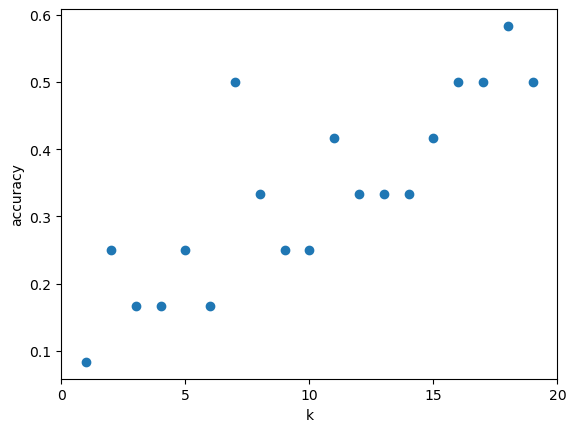

In [276]:
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

In [277]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 18)
knn.fit(X_train, y_train)

print('Training score: ', knn.score(X_train, y_train))
print('Test score: ', knn.score(X_test,y_test))
print('Predicted range: ', knn.predict(X_test_OKC.values.reshape(1,-1))[0])

Training score:  0.6285714285714286
Test score:  0.5833333333333334
Predicted range:  3


### Using Logistic Regression

In [278]:
from sklearn.linear_model import LogisticRegression

for this_C in [0.01, 0.1, 1, 10, 100]:
    clf = LogisticRegression(C=this_C).fit(X_train, y_train)
    
    test_score = clf.score(X_test, y_test)
    print('C = ', this_C, ', Test score: ', test_score)

C =  0.01 , Test score:  0.25
C =  0.1 , Test score:  0.25
C =  1 , Test score:  0.25
C =  10 , Test score:  0.25
C =  100 , Test score:  0.25


In [279]:
clf = LogisticRegression().fit(X_train, y_train)
print('Training score: ', clf.score(X_train, y_train))
print('Test score: ', clf.score(X_test,y_test))
print('Predicted range: ', clf.predict(X_test_OKC.values.reshape(1,-1)))

Training score:  0.9714285714285714
Test score:  0.25
Predicted range:  [3]


### Linear Kernel SVC

In [280]:
from sklearn.svm import SVC

for this_C in [0.01, 0.1, 1, 10, 100]:
    clf = SVC(kernel='linear', C=this_C).fit(X_train, y_train)
    
    test_score = clf.score(X_test, y_test)
    print('C = ', this_C, ', Test score: ', test_score)

C =  0.01 , Test score:  0.25
C =  0.1 , Test score:  0.25
C =  1 , Test score:  0.3333333333333333
C =  10 , Test score:  0.3333333333333333
C =  100 , Test score:  0.3333333333333333


In [281]:
clf = SVC(kernel='linear',C=1).fit(X_train,y_train)
print('Training score: ', clf.score(X_train,y_train))
print('Test score: ', clf.score(X_test,y_test))
print('Predicted range: ', clf.predict(X_test_OKC.values.reshape(1,-1)))

Training score:  0.9714285714285714
Test score:  0.3333333333333333
Predicted range:  [3]


### RBF Kernel SVC

In [282]:
from sklearn.svm import SVC

for this_C in [0.01, 0.1, 1, 10, 100]:
    clf = SVC(kernel='rbf', C=this_C).fit(X_train, y_train)
    
    test_score = clf.score(X_test, y_test)
    print('C = ', this_C, ', Test score: ', test_score)

C =  0.01 , Test score:  0.5
C =  0.1 , Test score:  0.5
C =  1 , Test score:  0.3333333333333333
C =  10 , Test score:  0.25
C =  100 , Test score:  0.25


In [283]:
clf = SVC(kernel='rbf', C = 0.1).fit(X_train,y_train)
print('Training score: ', clf.score(X_train,y_train))
print('Test score: ', clf.score(X_test,y_test))
print('Predicted range: ', clf.predict(X_test_OKC.values.reshape(1,-1)))

Training score:  0.45714285714285713
Test score:  0.5
Predicted range:  [2]


### Decision Tree Classifier

In [284]:
from sklearn.tree import DecisionTreeClassifier

for depth in range(1,21):
    dt = DecisionTreeClassifier(max_depth = depth).fit(X_train, y_train)
    test_score = dt.score(X_test, y_test)
    print ('Depth = ', depth, ', Test score: ', test_score)

Depth =  1 , Test score:  0.16666666666666666
Depth =  2 , Test score:  0.25
Depth =  3 , Test score:  0.25
Depth =  4 , Test score:  0.25
Depth =  5 , Test score:  0.25
Depth =  6 , Test score:  0.3333333333333333
Depth =  7 , Test score:  0.25
Depth =  8 , Test score:  0.3333333333333333
Depth =  9 , Test score:  0.3333333333333333
Depth =  10 , Test score:  0.3333333333333333
Depth =  11 , Test score:  0.3333333333333333
Depth =  12 , Test score:  0.3333333333333333
Depth =  13 , Test score:  0.3333333333333333
Depth =  14 , Test score:  0.3333333333333333
Depth =  15 , Test score:  0.3333333333333333
Depth =  16 , Test score:  0.25
Depth =  17 , Test score:  0.3333333333333333
Depth =  18 , Test score:  0.3333333333333333
Depth =  19 , Test score:  0.3333333333333333
Depth =  20 , Test score:  0.3333333333333333


In [285]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
print('Training score: ', dt.score(X_train, y_train))
print('Test score: ', dt.score(X_test,y_test))
print('Predicted range: ', dt.predict(X_test_OKC.values.reshape(1,-1)))

Training score:  1.0
Test score:  0.3333333333333333
Predicted range:  [3]


# Final Remarks:

From the above models, I was only able to get, at best, an accuracy of 58% using the k-nearest neighbors model.
The model predicts that the OKC Thunder will finish as a lottery team. However, I also understand that there are a LOT of factors in play when determining the future of a team, such as the overall talent of the team, the number and quality of future picks, the market size of the team, and the team's draft strategy (packaging picks to trade up) among many other factors. 

Overall, the project aims more towards refining and honing my skills on data science, especially on the data wrangling and engineering parts, while combining a passion of mine: basketball.